<a href="https://www.kaggle.com/code/caitlinruble/melanoma-detection-using-fastai-prototype?scriptVersionId=107691369" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This notebook is going to serve as the prototype for training the deep learning model for the [siim-isic-melanoma-classification challenge on Kaggle.](https://www.kaggle.com/competitions/siim-isic-melanoma-classification/) 

Goals:
1. Recreate the cleaned data frame of training image metadata, as explored in an earlier Data Wrangling and EDA notebook [here]( https://www.kaggle.com/code/caitlinruble/melanoma-classification-eda)
2. Create a subset of negative and positive images from the training set to serve as my "proof of concept" set as I set up the modeling process with FastAI
3. Load, train and validate the miniature data set using FastAI. Basically, go through the whole process I will eventually with the full dataset, except only with a small subset of data to save on computing power and time while I'm tinkering.



## Step 1: Load and clean train.csv as a Pandas DataFrame

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import imageio.v2 as imageio

sns.set_style('darkgrid')
plt.style.use('seaborn-notebook')

In [3]:
#read in train csv
train = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv')

#check for any missing values:
for col in train.columns:
    print(col + ' missing values: ' + str(train[col].isna().sum()))

image_name missing values: 0
patient_id missing values: 0
sex missing values: 65
age_approx missing values: 68
anatom_site_general_challenge missing values: 527
diagnosis missing values: 0
benign_malignant missing values: 0
target missing values: 0


This code block executes the data cleaning steps which were found to be necessary in the original data wrangling and cleaning notebook. The rationale behind each choice is fully explored and explained there.

In [4]:
#fill missing anatom site values with "unknown or other"
train.anatom_site_general_challenge.fillna('other or unknown', inplace=True)

#drop all rows from the train dataframe that are associated with 3 patients who are missing some data.
train.drop(train[(train['patient_id'] == 'IP_0550106') | (train['patient_id'] == 'IP_5205991') |(train['patient_id'] == 'IP_9835712')].index, inplace=True)

#check for any more missing values:
for col in train.columns:
    print(col + ' missing values: ' + str(train[col].isna().sum()))

image_name missing values: 0
patient_id missing values: 0
sex missing values: 0
age_approx missing values: 0
anatom_site_general_challenge missing values: 0
diagnosis missing values: 0
benign_malignant missing values: 0
target missing values: 0


In [5]:
#save cleaned train df as data

data = train

## Step 2: Create a subset of images that are positive and negative for the target class

In [6]:
#check percentage of positive images in entire training data set:

n_pos = len(data[data['target']==1])
print('number of images in full train set: {}'.format(len(data)))
print('Percentage of positive images in full train set: {:.1%}'.format(n_pos/len(data)))
print('Percentage of negative images in full train set: {:.1%}'.format(1 - n_pos/len(data)))

number of images in full train set: 33058
Percentage of positive images in full train set: 1.8%
Percentage of negative images in full train set: 98.2%


In [7]:
#Proportionally sample out 2.5% of the images (1.8% positive, 98.2% negative):

sub_data = data.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.025))
sub_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
32527,ISIC_9822801,IP_9387565,male,40.0,torso,nevus,benign,0
23640,ISIC_7180096,IP_5111235,male,35.0,lower extremity,unknown,benign,0
7061,ISIC_2207693,IP_5974691,female,35.0,torso,unknown,benign,0
2459,ISIC_0834745,IP_6512345,male,70.0,torso,unknown,benign,0
21471,ISIC_6514525,IP_7911457,female,50.0,torso,nevus,benign,0


In [8]:
#check percentage of positive images in the data subset:

n_pos = len(sub_data[sub_data['target']==1])
print('Number of images in subset of data: {}'.format(len(sub_data)))
print('Subset of data as a percentage of all image data: {:.1%}'.format(len(sub_data)/len(data)))
print('Number of positive images: {}'.format(n_pos))
print('Percentage of positive images in subset: {:.1%}'.format(n_pos/len(sub_data)))
print('Number of negative images: {}'.format(len(sub_data) - n_pos))
print('Percentage of negative images in subset: {:.1%}'.format(1 - n_pos/len(sub_data)))

Number of images in subset of data: 827
Subset of data as a percentage of all image data: 2.5%
Number of positive images: 15
Percentage of positive images in subset: 1.8%
Number of negative images: 812
Percentage of negative images in subset: 98.2%


Excellent! Now I have a small subset of the original training data set, proportionally split by the target field to build and test my propotype deep learning model. I'm going to modify the image_name column to reflect the full image path for the FastAI ImageDataLoader object to read in the next step.

In [9]:
#train_path = '../input/siim-isic-melanoma-classification/jpeg/train'
#test_path = '../input/siim-isic-melanoma-classification/jpeg/test'

#sub_data['image_name'] = sub_data['image_name'].apply(lambda x: x + '.jpg')
#sub_data['image_name'] = sub_data['image_name'].apply(lambda x: os.path.join(train_path,x))

In [10]:
#sub_data.head()

## Part 3: Build deep-learning classifier prototype with fastAI

In [11]:
#hide output
!pip install -Uqq fastbook --quiet
!pip install ipywidgets

#jupyter nbextension enable --py widgetsnbextension

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.6.4 which is incompatible.
pandas-profiling 3.1.0 requires mar

In [12]:
import fastbook
fastbook.setup_book()
import fastai

from fastbook import *
from fastai.vision.all import *
from fastai.tabular.all import *
from fastai.medical.imaging import *
import torch
from pathlib import Path
from PIL import Image
from tqdm import tqdm

In [13]:
#ensure GPU is running
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [1]:
#create dataloaders object of class ImageDataLoaders from the sub_data df
jpg_path = '../input/siim-isic-melanoma-classification/jpeg'

#dls = ImageDataLoaders.from_df(df = sub_data,
#                               path = '',
#                               label_col = 6,
#                               valid_pct = 0.2,
#                               seed=1,
#                               bs = 24,
#                               device=device,
#                               item_tfms = Resize(128))

dls = ImageDataLoaders.from_df(df = sub_data, #specify df holding image names
                               path = jpg_path,    #set path for where to find images
                               folder = 'train',   #specify looking specifically in the 'train' folder for this dls
                               suff = '.jpg',      #add the .jpg suffix to file names from df
                               label_col = 6,      #col 6 holds label info 'benign' or 'malignant'
                               valid_pct = 0.2,    #20% of images will be held for validation
                               bs = 8,            #set batch size
                               device=device,      #set device
                               item_tfms = Resize(128))    #resize images as they're loaded

dls.show_batch()

NameError: name 'ImageDataLoaders' is not defined

In [20]:
#create the vision learner

learn = vision_learner(dls,                  #specify dataloader object
                       resnet18,             #specify a pre-trained model we want to build off of
                       metrics=RocAucBinary, #specify metric we want to optimize
                       model_dir = '/kaggle/working')   #specify output location to store model

In [16]:
#This cell is taking *way* too long to run, and not utilizing the GPU. 
#A forum search shows that others have run into the same issue with this dataset
#The CPU is being used to resize the images, which it turns out takes a long time
#The solution: resize the images prior to feeding them to the data learner.


#learn.lr_find()

The previous cell is taking *way* too long to run, and not utilizing the GPU. The cell below shows that the GPU is mounted and running, so why isn't it being used when I run the lr_find() method on the learner?

A forum search shows that others have run into the same issue with this dataset.\
The CPU is being used to resize the images, which it turns out takes a long time.

The solution: resize the images prior to feeding them to the data learner.

In [24]:
print(torch.__version__)
print(fastai.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.backends.cudnn.enabled)
print(dls.device)

1.11.0
2.7.9
True
Tesla P100-PCIE-16GB
True
cuda:0


I want to resize all the images in ../jpeg to be size 512 prior to feeding them into the data loader....how to do this?

idea 1: move copies of the images into my kaggle working directory and resize them there

idea 2: use a resized dataset someone else has already made (e.g. https://www.kaggle.com/datasets/sarques/siimisic-melanoma-1024jpeg)

idea 3: can I somehow resize the images directly before feeding them to dls?

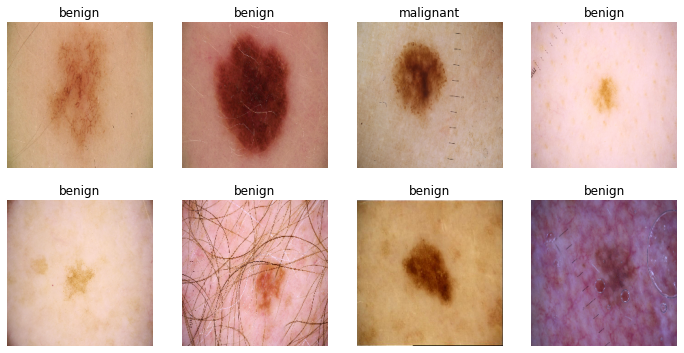

In [52]:
#try method 2 first, to see if I can get this working at all
#for this I actually ended up going with a 224 image size

path_224 = '../input/siic-isic-224x224-images'

dls2 = ImageDataLoaders.from_df(df = sub_data, #specify df holding image names
                               path = path_224,    #set path for where to find images
                               folder = 'train',   #specify looking specifically in the 'train' folder for this dls
                               suff = '.png',      #add the .png suffix to file names from df
                               label_col = 6,      #col 6 holds label info 'benign' or 'malignant'
                               splitter=RandomSplitter(valid_pct=0.2, seed=42),    #20% of images will be held for validation
                               bs = 8,            #set batch size
                               device=device)      #set device
                              # item_tfms = Resize(128))    #resize images as they're loaded

dls2.show_batch()

In [64]:
#instantiate the rocaucbinary metric
rocAucBinary = RocAucBinary()

#create the vision learner

learn2 = vision_learner(dls2,                  #specify dataloader object
                       models.vgg16_bn,             #specify a pre-trained model we want to build off of
                       metrics=[rocAucBinary], #specify metric we want to optimize
                       model_dir = '/kaggle/working')   #specify output location to store model

In [ ]:
#lets fine-tune the last layers of the vgg16 model through 6 epochs
#learn2.fine_tune(6)

In [ ]:
#Unfortunately, the ImageClassiferCleaner method doesn't jive with the dls object which pulls information from a DataFrame


#from fastai.vision.widgets import ImageClassifierCleaner

#cleaner = ImageClassifierCleaner(learn2)
#cleaner

In [ ]:
#try to set this up so that model stops training when the roc_auc_score metric increases
#learn2.fit(6, cbs=EarlyStoppingCallback(monitor='roc_auc_score', patience=1))

SuggestedLRs(minimum=0.06309573650360108, steep=0.0004786300996784121, valley=0.02754228748381138, slide=0.0063095735386013985)

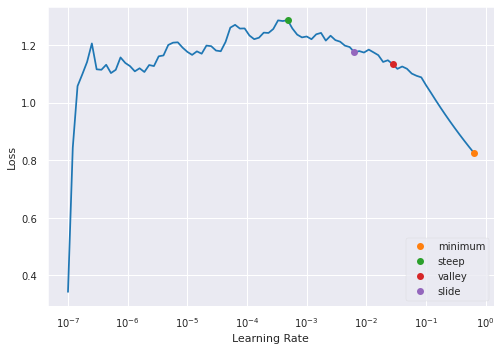

In [65]:
learn2.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [56]:
#learn2.fit(6, lr=0.1, cbs=SaveModelCallback(monitor='roc_auc_score', fname = 'vgg16_subset', comp = np.greater, with_opt=True))

epoch,train_loss,valid_loss,roc_auc_score,time
0,5.745255,3075.097656,0.800412,00:10
1,3.204201,98213.945312,0.526749,00:09
2,3.312344,3964.873047,0.575103,00:10
3,3.030539,137.616074,0.472222,00:09
4,3.283775,9256.670898,0.456790,00:09
5,5.729958,3375.967529,0.481481,00:10


Better model found at epoch 0 with roc_auc_score value: 0.8004115226337449.


In [66]:
#use the valley method to set the base_lr: 0.0275
learn2.fine_tune(10, base_lr=0.0275, cbs=SaveModelCallback(monitor='roc_auc_score', fname = 'vgg16_subset', comp = np.greater, with_opt=True))

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.469367,0.392285,0.465021,00:09


Better model found at epoch 0 with roc_auc_score value: 0.46502057613168724.


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.247401,0.384222,0.541152,00:13
1,0.220754,0.378039,0.244856,00:13
2,0.260668,0.130077,0.831276,00:13
3,0.239212,0.131670,0.617284,00:13
4,0.187819,0.195578,0.705761,00:13
5,0.283135,0.155867,0.732510,00:13
6,0.254476,0.184713,0.452675,00:13
7,0.157048,0.149767,0.609053,00:13
8,0.123389,0.151560,0.516461,00:13
9,0.153600,0.153722,0.522634,00:13


Better model found at epoch 0 with roc_auc_score value: 0.5411522633744856.
Better model found at epoch 2 with roc_auc_score value: 0.8312757201646092.


For the vgg16_bn pre-trained model, fine-tuning over 10 epochs leads to a max roc_auc_score of 0.83 after epoch 2. The best model has been saved as "vgg16_subset.pth" in the kaggle working directory.
This is good starting place, but I definitely want to improve that performance. 

The very top teams for this competition were able to achieve roc_auc scores of 0.95 in their submission.

What can I tinker with?

    1. which pre-trained model I start with
    2. batch size
    3. learning rate
    4. the proportion and quantity of malignant images the model is allowed to train on
    5. Preprocessing steps with the images; I could try transformations like random croping, rotation, using grayscale, etc.
   
First, I'm going to jump over to ResNet34 and see how that does.

In [67]:
#leverage the resnet34 pretrained CNN model
learn3 = vision_learner(dls2,                  #specify dataloader object
                       models.resnet34,             #specify a pre-trained model we want to build off of
                       metrics=[rocAucBinary], #specify metric we want to optimize
                       model_dir = '/kaggle/working')   #specify output location to store model

SuggestedLRs(minimum=0.017378008365631102, steep=9.12010818865383e-07, valley=0.0063095735386013985, slide=0.007585775572806597)

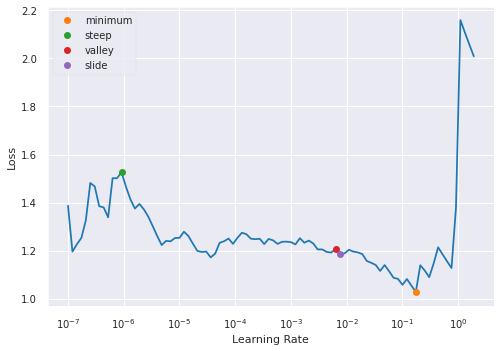

In [61]:
learn3.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [69]:
#use the min method to set the base_lr: 0.0174
learn3.fine_tune(10, base_lr=0.0174, cbs=SaveModelCallback(monitor='roc_auc_score', fname = 'resnet34_subset', comp = np.greater, with_opt=True))

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.320292,0.193516,0.786008,00:08


Better model found at epoch 0 with roc_auc_score value: 0.7860082304526749.


epoch,train_loss,valid_loss,roc_auc_score,time
0,0.227936,0.233341,0.701646,00:09
1,0.249580,0.254204,0.520576,00:09
2,0.177610,0.204637,0.874486,00:08
3,0.130937,0.201373,0.851852,00:08
4,0.162090,0.240311,0.611111,00:10
5,0.136466,0.182414,0.855967,00:08
6,0.150018,0.160089,0.808642,00:08
7,0.102409,0.130763,0.763374,00:09
8,0.085404,0.168043,0.681070,00:08
9,0.040546,0.152718,0.732510,00:09


Better model found at epoch 0 with roc_auc_score value: 0.7016460905349795.
Better model found at epoch 2 with roc_auc_score value: 0.874485596707819.


The highest roc_auc_score for the resnet 34 based-model reached 0.87 after epoch 2. The epochs trained more quickly, in under 10s for each epoch v. the 13s per epoch when using the vgg16_bn model. 

**Conclusion:** resnet34 is achieving higher performance with this training set, and does so with lower computational cost.

## Part IV: Use the best model to make predictions for the submission.

Here are the submission guidelines for the Kaggle competition:

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

Submission File
For each image_name in the test set, you must predict the probability (target) that the sample is malignant. The file should contain a header and have the following format:

image_name,target

ISIC_0052060,0.7

ISIC_0052349,0.9

ISIC_0058510,0.8

ISIC_0073313,0.5

ISIC_0073502,0.5

etc.


In [87]:
#load the resnet34 learner as "model"
model = learn3.load('resnet34_subset', with_opt=True, strict=True)

#read in test csv
test = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')

test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [88]:
#Initialize a list of image names containing all the images from test
test_ims = test['image_name'].to_list()
print(f"number of test images: {len(test_ims)}")

#initialize a dict to hold results
predictions = {}


number of test images: 10982


In [90]:
#test_path
test_path = '../input/siic-isic-224x224-images/test/'

#import ImageIO
import imageio.v2 as imageio

for image in range(10):
    #set the image name
    image_name = test_ims[image]
    image_path = test_path + image_name +'.png'

    #load the image
    im = imageio.imread(image_path)

    #use the model to make the prediction
    category, _, probs = model.predict(im)
    
    predictions[image_name] = f"{probs[1]:.1f}"
    print(image + ' | ' image_name + ", " + f"{probs[1]:.1f}")
    
    #append the probability the image is malignant to the probs_mal list
    #probs_mal.append(f"{probs[1]:.1f}")
    


ISIC_0052060: 0.0


ISIC_0052349: 0.0


ISIC_0058510: 0.0


ISIC_0073313: 0.0


ISIC_0073502: 0.0


ISIC_0074618: 0.0


ISIC_0076801: 0.0


ISIC_0077586: 0.0


ISIC_0082004: 0.0


ISIC_0082785: 0.0


In [ ]:
#this was just me playing around with pulling the probability information out of the model predictions. 
#Saved for future reference.

#print(category)
#print(_)
#print(probs)
#print(probs[1])
#print(f"{probs[1]:.1f}")
#prob_mal = f"{probs[1]:.1f}"
#print(prob_mal)

In [92]:
predictions

{'ISIC_0052060': '0.0',
 'ISIC_0052349': '0.0',
 'ISIC_0058510': '0.0',
 'ISIC_0073313': '0.0',
 'ISIC_0073502': '0.0',
 'ISIC_0074618': '0.0',
 'ISIC_0076801': '0.0',
 'ISIC_0077586': '0.0',
 'ISIC_0082004': '0.0',
 'ISIC_0082785': '0.0'}

In [105]:
submission = pd.DataFrame.from_dict(predictions, orient='index')
submission.reset_index(inplace=True)
submission.rename(columns={'index':'image_name','0':'target'})

submission.to_csv("submission.csv", index=False)
submission.head()


,index,0
0,ISIC_0052060,0.0
1,ISIC_0052349,0.0
2,ISIC_0058510,0.0
3,ISIC_0073313,0.0
4,ISIC_0073502,0.0


In [106]:
#check to make sure output looks like I want it to. Looks good.
pd.read_csv('./submission.csv')

,index,0
0,ISIC_0052060,0.0
1,ISIC_0052349,0.0
2,ISIC_0058510,0.0
3,ISIC_0073313,0.0
4,ISIC_0073502,0.0
5,ISIC_0074618,0.0
6,ISIC_0076801,0.0
7,ISIC_0077586,0.0
8,ISIC_0082004,0.0
9,ISIC_0082785,0.0


## Part V: export the best model as a pkl file

In [ ]:
model.export('/kaggle/working/resnet34_subsample_proportional.pkl')